In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
def obstacle(x, y, W1=1, r=(1, 1), c=(0, 0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0]**2 + (y - c[1])**2/r[1]**2)**20 + 1

    return W1 / ellipse

def obstacle_dx(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0]**2 + (y - c[1])**2/r[1]**2
    numer = -40 * W1 * (x-c[0])*(circle)**19
    denom = r[0]**2*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0]**2 + (y - c[1])**2/r[1]**2
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]**2*((circle)**20 + 1)**2

    return numer / denom

# Avoidance of Single Moving Object
For the optimal path of an object avoiding one other object all you need to do is modify the example from the object avoidance lab.

We have the following state matrix:
$$\begin{align}
s=\begin{bmatrix}
x(t)\\
y(t)\\
\dot x(t)\\
\dot y(t)
\end{bmatrix}=\begin{bmatrix}
\dot x(t)\\
\dot y(t)\\
u_1(t)\\
u_2(t)
\end{bmatrix}
\end{align}$$
Where $u_1,u_2$ are our control variables

We add an additional item to our cost we call obstacle, that penalizes getting too close to the obstacle. This is given by:
$$\begin{align}
C_o=\frac{1}{(\frac{(x-c_x(t))^2}{r_x^2}+ \frac{(y-c_y(t))^2}{r_y^2})^{20}+1}
\end{align}$$
Where $x,y$ are the position of our control object and $c_x(t),c_y(t)$ are the positions of the avoidance object at a particular time. We can control the radius of this object with $r_x,r_y$.

We can thus set up our cost functional:
$$\begin{align}
\int_{t_0}^{t_f}1+W_1C_o(t)+W_2||\mathbf{u}(t)||^2dt
\end{align}$$
Here the 1 penalizes taking too long, the $W_1$ penalizes running into the object (we would want this to be big), and $W_2$ penalizes accelerating too much.

We form a hamiltonian by:
$$\begin{align}
H(t,s,u,p)=\langle p,\dot s\rangle-L(t,s,u)\\
=p_1\dot x_1 + p_2 \dot x_2+ p_3 u_1+ p_4u_2 - (1+W_1C_o + W_2(u_1^2+u_2^2))
\end{align}$$
Where $p$ is called the costate variables. We know that first we have:
$$\begin{align}
\dot p = -H_s\\
\begin{bmatrix}
\dot p_1\\
\dot p_2\\
\dot p_3\\
\dot p_4
\end{bmatrix}=\begin{bmatrix}
\frac{d}{dx}    C_o\\
\frac{d}{dy}C_o \\
-p_1\\
-p_2
\end{bmatrix}
\end{align}$$
We then also know that
$$\begin{align}
H_u=0\\
\begin{bmatrix}
u_1\\
u_2
\end{bmatrix}=\begin{bmatrix}
\frac{1}{2W_2}p_3\\
\frac{1}{2W_2}p_4
\end{bmatrix}
\end{align}$$
This yields the whole system of equations:
$$\begin{align}
\begin{bmatrix}
x\\
y\\
\dot x\\
\dot y\\
p_1\\
p_2\\
p_3\\
p_4
\end{bmatrix}' =\begin{bmatrix}
\dot x  \\
\dot y\\
\frac{1}{2W_2}p_3\\
\frac{1}{2W_2}p_4\\
\frac{d}{dx}C_o \\
\frac{d}{dy}C_o \\
-p_1\\
-p_2
\end{bmatrix}
\end{align}$$
Which we can solve using ```solve_bvp```

Text(0.5, 1.0, 'Control Variables')

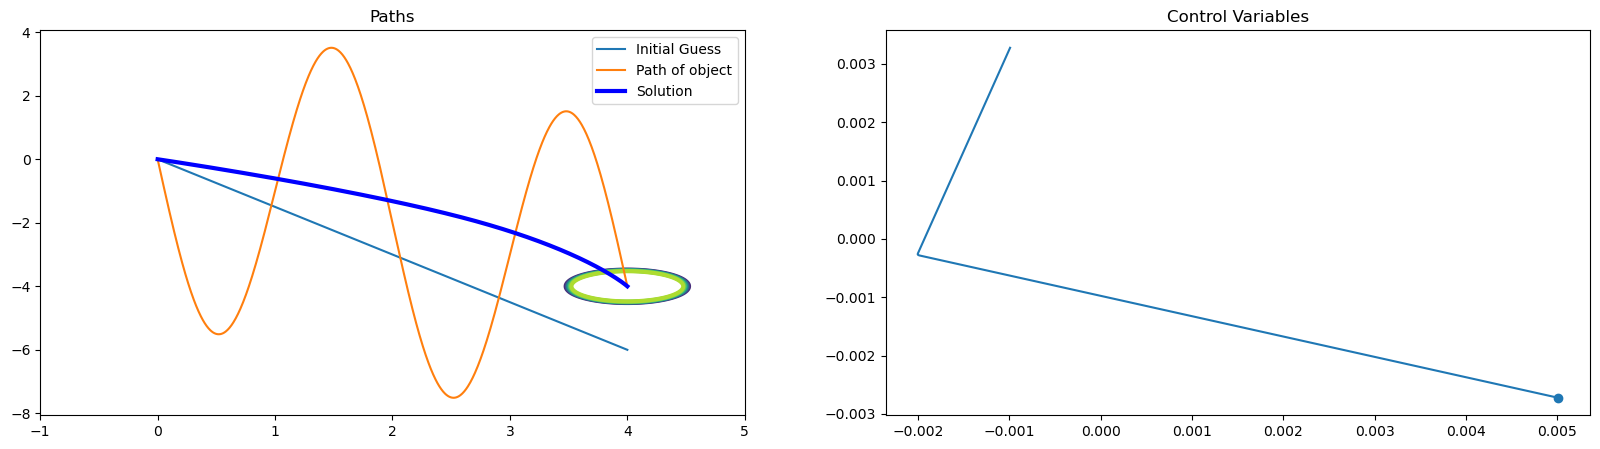

In [36]:
def c_f(t):
    """
    Path of Object we need to avoid
    """
    return (4-t,t-4+5*np.sin(np.pi*t))
def func(t, vars):
    """
    Defines what to return as the derivative
    """
    x, y, dx, dy, p1, p2, p3, p4 = vars
    c = c_f(t)
    return np.array([dx,
                        dy,
                        1/(2*W2)*p3,
                        1/(2*W2)*p4,
                        obstacle_dx(x, y, W1=W1, r=r, c=c),
                        obstacle_dy(x, y, W1=W1, r=r, c=c),
                        -p1,
                        -p2
            ])  
def bc(ya,yb):
    """
    Boundary Conditions
    """
    return np.array([
        ya[0],ya[1],ya[2],ya[3],
        yb[0]-4,yb[1]+4,yb[2],yb[3]
    ])
    
# Define how to weight the obstacles
W1 = 800
# Define how to weight the energy consumption
W2 = .001
# Define the radius and starting location of object
r = (.5,.5)
c = c_f(0)

# Define how many steps we are taking
t_steps=1000

# Plot the location of the object
x  = np.linspace(-1,5,t_steps)
y  = np.linspace(1,-5,t_steps)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.contour(X, Y, obstacle(X, Y, W1, r, c), linewidths=3)

# Define the initial guess for our trajectory
y0 = np.ones((8, t_steps))
t = np.linspace(0, 4, t_steps)
y1 = t
y2 = -1.5*t
y0[0,:] = y1
y0[1,:] = y2
y0[3,:] = -1*np.ones(t_steps)   
plt.plot(y1,y2,label="Initial Guess")

# Solve the system
sol = solve_bvp(func, bc, t, y0, max_nodes=30_000)
plt.plot(c_f(t)[0],c_f(t)[1], label="Path of object")
# Plot the solution
plt.plot(sol.sol(t)[0],sol.sol(t)[1], color="b", linewidth=3, label="Solution")
plt.title("Paths")
plt.legend()

# Plot the proportional control
plt.subplot(122)
plt.scatter(sol.sol(t)[6][0],sol.sol(t)[7][0])
plt.plot(sol.sol(t)[6],sol.sol(t)[7])
plt.title("Control Variables")

## Creation of Video

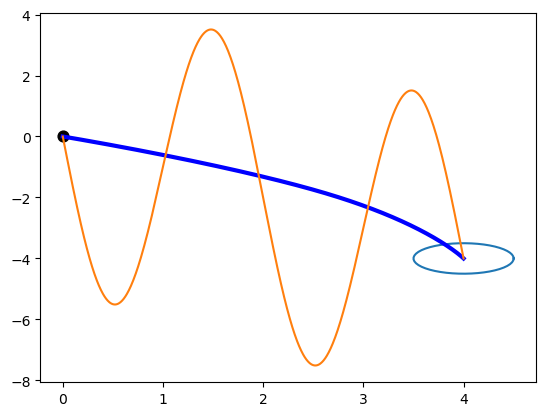

In [30]:
# Make the 
# Define our circle and linspace
theta = np.linspace(0,2*np.pi)
t = np.linspace(0, 4, t_steps)

# Get the figure and plot our objects
fig = plt.figure()
circle, = plt.plot(c_f(0)[0]+r[0]*np.cos(theta),c_f(0)[1]+r[0]*np.sin(theta))
plt.plot(sol.sol(t)[0],sol.sol(t)[1], color="b", linewidth=3, label="Solution")
plt.plot(c_f(t)[0],c_f(t)[1], label="Path of object")
scat = plt.scatter([sol.sol(0)[0]],[sol.sol(0)[1]], s=60, color="k")
# Define update function to update obstacle and ship
def update(i):
    circle.set_data(c_f(t[i])[0]+r[0]*np.cos(theta),c_f(t[i])[1]+r[0]*np.sin(theta))
    scat.set_offsets([sol.sol(t[i])[0],sol.sol(t[i])[1]])
    return circle
frames = np.arange(len(t))
ani = FuncAnimation(fig, update, frames=frames, interval = 20)
ani.save("single_object.mp4", writer="ffmpeg", fps=100, bitrate=1800, dpi=100)

# Derivation of Multiple Controllable Objects
In contrast to before, assuming we have n controllable objects, we will have to keep track of n states. If we just add them to the E-L we get the following equations
$$\begin{align}
\int_{t_0}^{t_f}1+\sum_{k=1}^n W_1(\sum_{i\neq k}C^i_o(t))+W_2||\mathbf{u_k}(t)||^2dt
\end{align}$$
Where $C_o^i$ is the cost of of intersection with the ith object and $u_k$ is the $kth$ control variable.

Now we will have a system of $8n$ differential equations. Each block would thus look like:
$$\begin{align}
\begin{bmatrix}
x_k\\
y_k\\
\dot x_k\\
\dot y_k\\
p_{1k}\\
p_{2k}\\
p_{3k}\\
p_{4k}
\end{bmatrix}' =\begin{bmatrix}
\dot x_k  \\
\dot y_k\\
\frac{1}{2W_2}p_{3k}\\
\frac{1}{2W_2}p_{4k}\\
\sum_{i\neq k}\frac{d}{dx}C^i_o \\
\sum_{i\neq k}\frac{d}{dy}C^i_o \\
-p_{1k}\\
-p_{2k}
\end{bmatrix}
\end{align}$$
We implement this down below. Note initial guesses are incredibly important

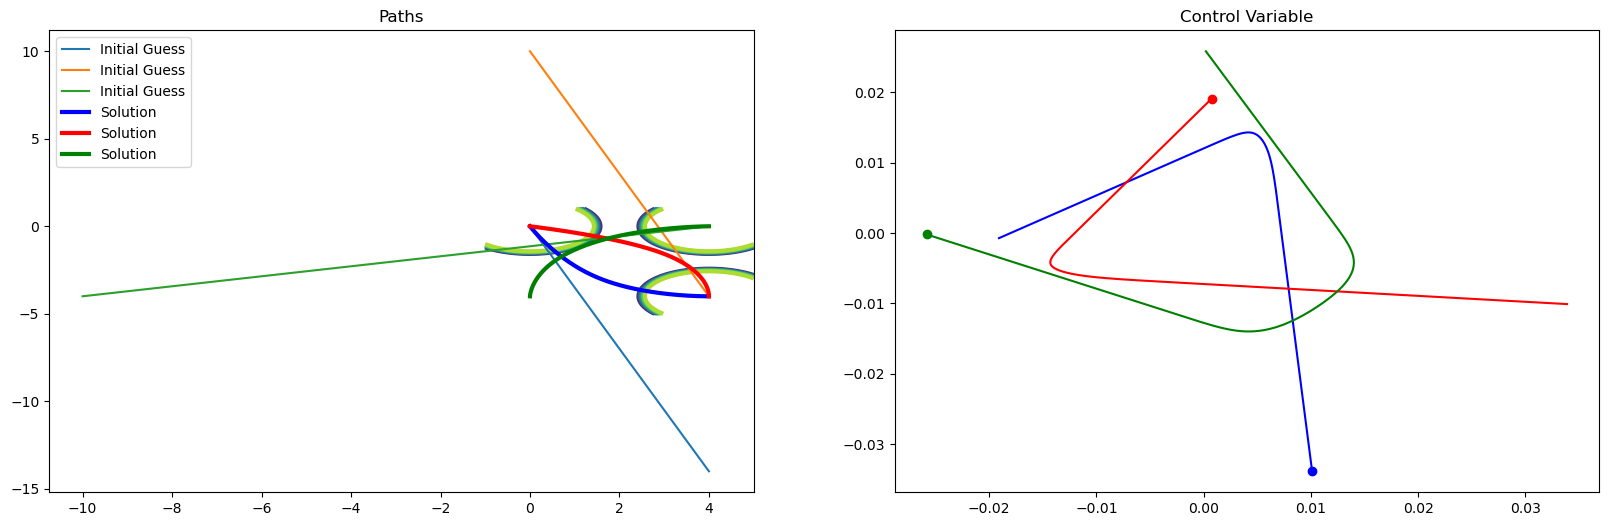

In [34]:
def c_f(t):
    """
    This function defines the path of the object
    """
    return (4-t,t-4+.5*np.sin(20*t))
def func(t, vars):
    """
    This function defines the derivative
    """
    x1, y1, dx1, dy1, p11, p21, p31, p41,\
    x2, y2, dx2, dy2, p12, p22, p32, p42,\
    x3, y3, dx3, dy3, p13, p23, p33, p43,    = vars
    return np.array([dx1,
                        dy1,
                        1/(2*W2)*p31,
                        1/(2*W2)*p41,
                        obstacle_dx(x1, y1, W1=W1, r=r, c=(x2,y2))+obstacle_dx(x1, y1, W1=W1, r=r, c=(x3,y3)),
                        obstacle_dy(x1, y1, W1=W1, r=r, c=(x2,y2))+obstacle_dy(x1, y1, W1=W1, r=r, c=(x3,y3)),
                        -p11,
                        -p21,
                        dx2,
                        dy2,
                        1/(2*W2)*p32,
                        1/(2*W2)*p42,
                        obstacle_dx(x2, y2, W1=W1, r=r, c=(x1,y1))+obstacle_dx(x2, y2, W1=W1, r=r, c=(x3,y3)),
                        obstacle_dy(x2, y2, W1=W1, r=r, c=(x1,y1))+obstacle_dy(x2, y2, W1=W1, r=r, c=(x3,y3)),
                        -p12,
                        -p22,
                        dx3,
                        dy3,
                        1/(2*W2)*p33,
                        1/(2*W2)*p43,
                        obstacle_dx(x3, y3, W1=W1, r=r, c=(x1,y1))+obstacle_dx(x3, y3, W1=W1, r=r, c=(x2,y2)),
                        obstacle_dy(x3, y3, W1=W1, r=r, c=(x1,y1))+obstacle_dy(x3, y3, W1=W1, r=r, c=(x2,y2)),
                        -p13,
                        -p23
            ])  
def bc(ya,yb):
    """
    This function defines the boundary conditions
    """
    return np.array([
        ya[0],ya[1],ya[2],ya[3],
        yb[0]-4,yb[1]+4,yb[2],yb[3],
        ya[8]-4,ya[9]+4,ya[10],ya[11],
        yb[8],yb[9],yb[10],yb[11],
        ya[16]-4,ya[17],ya[18],ya[19],
        yb[16],yb[17]+4,yb[18],yb[19]
    ])
    
# Define how to weight the obstacles
W1 = 200
# Define how to weight the energy consumption
W2 = .005
# Define the radius and starting location of object
r = (1.5,1.5)

# Define how many steps we are taking
t_steps=1000

# Plot the location of the object
x  = np.linspace(-1,5,t_steps)
y  = np.linspace(1,-5,t_steps)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(20,6))
plt.subplot(121)

plt.contour(X, Y, obstacle(X, Y, W1, r, (4,-4)), linewidths=3)
plt.contour(X, Y, obstacle(X, Y, W1, r, (0,0)), linewidths=3)
plt.contour(X, Y, obstacle(X, Y, W1, r, (4,0)), linewidths=3)

# Define the initial guess for our trajectory
y0 = np.ones((24, t_steps))
t = np.linspace(0, 4, t_steps)
y0[0,:] = t
y0[1,:] = -3.5*t
y0[3,:] = -1*np.ones(t_steps)   
y0[8,:] = 4-t
y0[9,:] = -4+t*3.5
y0[10,:] = -1*np.ones(t_steps)   
y0[16,:] = 4-t*3.5
y0[17,:] = -t
y0[19,:] = -1*np.ones(t_steps)   
plt.plot(y0[0,:],y0[1,:],label="Initial Guess")
plt.plot(y0[8,:],y0[9,:],label="Initial Guess")
plt.plot(y0[16,:],y0[17,:],label="Initial Guess")

# Solve the system
sol = solve_bvp(func, bc, t, y0, max_nodes=30_000)
# Plot the solution
plt.plot(sol.sol(t)[0],sol.sol(t)[1], color="b", linewidth=3, label="Solution")
plt.plot(sol.sol(t)[8],sol.sol(t)[9], color="r", linewidth=3, label="Solution")
plt.plot(sol.sol(t)[16],sol.sol(t)[17], color="g", linewidth=3, label="Solution")
plt.legend()
plt.title("Paths")
plt.subplot(122)

plt.title("Control Variable")
plt.scatter(sol.sol(t)[6][0],sol.sol(t)[7][0], color="b")
plt.plot(sol.sol(t)[6],sol.sol(t)[7], color="b")
plt.scatter(sol.sol(t)[14][0],sol.sol(t)[15][0], color="r")
plt.plot(sol.sol(t)[14],sol.sol(t)[15], color="r")
plt.scatter(sol.sol(t)[22][0],sol.sol(t)[23][0], color="g")
plt.plot(sol.sol(t)[22],sol.sol(t)[23], color="g")


## Creation of video

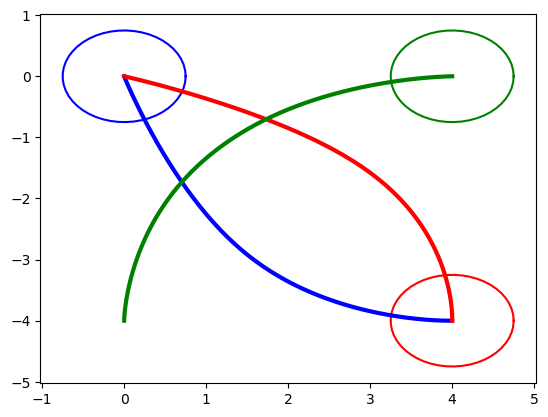

In [35]:
# Define our circle and linspace
theta = np.linspace(0,2*np.pi)
t = np.linspace(0, 4, t_steps)

# Get the figure and plot our objects
fig = plt.figure()
circle1, = plt.plot(r[0]/2*np.cos(theta),r[0]/2*np.sin(theta), color="b")
circle2, = plt.plot(4+r[0]/2*np.cos(theta),-4+r[0]/2*np.sin(theta), color = "r")
circle3, = plt.plot(4+r[0]/2*np.cos(theta),r[0]/2*np.sin(theta), color = "g")
plt.plot(sol.sol(t)[0],sol.sol(t)[1], color="b", linewidth=3, label="Solution")
plt.plot(sol.sol(t)[8],sol.sol(t)[9], color="r", linewidth=3, label="Solution")
plt.plot(sol.sol(t)[16],sol.sol(t)[17], color="g", linewidth=3, label="Solution")

# Define update function to update obstacle and ship
def update(i):
    circle1.set_data(sol.sol(t[i])[0]+r[0]/2*np.cos(theta),sol.sol(t[i])[1]+r[0]/2*np.sin(theta))
    circle2.set_data(sol.sol(t[i])[8]+r[0]/2*np.cos(theta),sol.sol(t[i])[9]+r[0]/2*np.sin(theta))
    circle3.set_data(sol.sol(t[i])[16]+r[0]/2*np.cos(theta),sol.sol(t[i])[17]+r[0]/2*np.sin(theta))
    return circle1,circle2,circle3
frames = np.arange(len(t))
ani = FuncAnimation(fig, update, frames=frames, interval = 20)
ani.save("3_controllable_objects.mp4", writer="ffmpeg", fps=100, bitrate=1800, dpi=100)